# Plot single graphs

In [1]:
from model_complex import Calibration, EpidData, FactoryBRModel
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def optuna_annealing_plot(epid_data, method, type):
    epid_data.get_wave_data(regime=type)
    data = epid_data.prepare_for_calibration()
    rho = epid_data.get_rho()//10

    if type == 'age':
        init_infect = [100, 100]
        model = FactoryBRModel.age_group()
        label = {0: '0-14 years', 1: '15+ years'}
    else:
        init_infect = [100]
        model = FactoryBRModel.total()
        label = {0: 'total'}

    calibration = Calibration(init_infect, model, data, rho)

    if method == 'annealing':
        alpha, beta = calibration.annealing_calibration()
    else:
        alpha, beta = calibration.optuna_calibration()

    res = model.get_result()
    plot_data = epid_data.prepare_for_plot()

    color = {0: 'blue', 1: 'orange'}
    for i in range(len(res)):
        d = plot_data[:, i]
        m = res[i]
        l = max(max(m),max(d))/len(res)
        plt.text(0, l+i*l, f'R2_{i}: {round(r2_score(d, m),2)}')
        plt.plot(m, label=label[i], color=color[i])
        plt.plot(d, '--o', color=color[i])
    plt.title(f"{method.capitalize()}, {type.capitalize()}")
    plt.legend()
    plt.plot()
    

def abc_plot(epid_data, type, epsilon=3000):
    epid_data.get_wave_data(regime=type)
    data = epid_data.prepare_for_calibration()
    rho = epid_data.get_rho()//10

    if type == 'age':
        init_infect = [100, 100]
        model = FactoryBRModel.age_group()
        label = {0: '0-14 years', 1: '15+ years'}
    else:
        init_infect = [100]
        model = FactoryBRModel.total()
        label = {0: 'total'}

    calibration = Calibration(init_infect, model, data, rho)

    alpha, beta = calibration.abc_calibration(epsilon=epsilon)

    color = {0: 'blue', 1: 'orange'}

    for a, b in zip(zip(*alpha), zip(*beta)):

        model.simulate(
            alpha=a, 
            beta=b, 
            initial_infectious=init_infect, 
            rho=rho, 
            modeling_duration=len(data)
        )
        res = model.get_result()
        for i in range(len(res)):
            plt.plot(res[i], lw=0.3, alpha=0.5, color=color[i])

    model.simulate(
        alpha=[a.mean() for a in alpha], 
        beta=[b.mean() for b in beta], 
        initial_infectious=init_infect, 
        rho=rho, 
        modeling_duration=len(data)//len(init_infect)
    )

    res = model.get_result()
    plot_data = epid_data.prepare_for_plot()
    
    for i in range(len(res)):
        d = plot_data[:, i]
        m = res[i]
        l = max(max(m),max(d))/len(res)
        plt.text(0, l+i*l, f'R2_{i}: {round(r2_score(d, m),2)}')
        plt.plot(m, label=label[i], color=color[i])
        plt.plot(d, '--o', color=color[i])
    plt.title(f"ABC, {type.capitalize()}")
    plt.legend()
    plt.plot()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Single example

In [2]:
epid_data = EpidData(city='samara', path='./', 
                start_time='01-07-2015', end_time='20-06-2016')

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


/home/luhter/model_complex/.venv/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (6) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


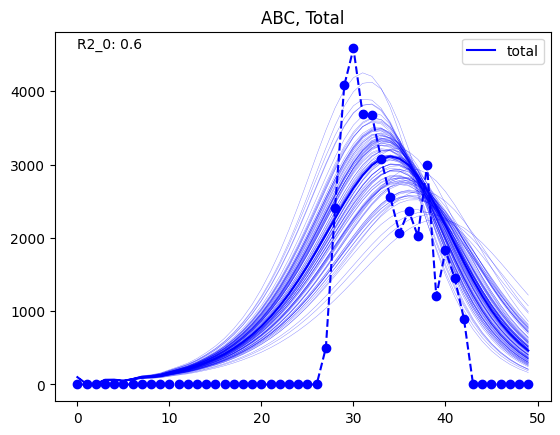

In [4]:
abc_plot(epid_data, 'total', epsilon=1000)

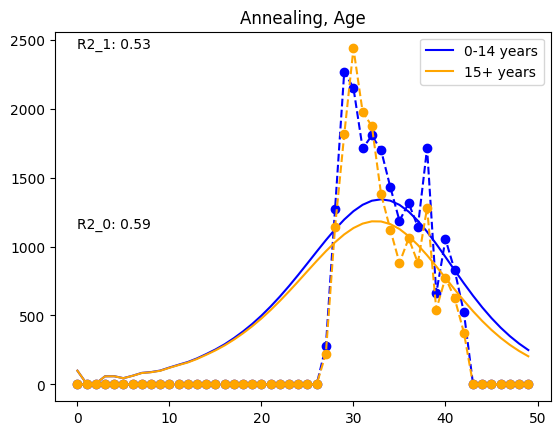

In [8]:
optuna_annealing_plot(epid_data, 'annealing', 'age')

# Plot multiple graphics

In [9]:
from model_complex import Calibration, EpidData, FactoryBRModel
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import time

def opt_ann_plots(st_year, years, type, city, method):

    if type == 'age':
        groups = 2
        legend_dict = {0: '0-14 years', 1: '15+ years'}
        model = FactoryBRModel.age_group()
        init_infect = [100, 100]
    else:
        groups = 1
        legend_dict = {0: 'total'}
        model = FactoryBRModel.total()
        init_infect = [100]
        

    fig, ax = plt.subplots(years, groups, figsize=(groups*5, years*2.5))

    if groups == 1:
        for i in range(years):
            ax[i] = [ax[i]]

    color = {0: 'blue', 1: 'orange'}
    main_color = {0: 'red', 1: 'green'}

    for i in range(years):
        epid_data = EpidData(city=city, path='./', 
                    start_time=f'01-07-{st_year + i}', end_time=f'20-06-{st_year + i + 1}')
        epid_data.get_wave_data(regime=type)
        data = epid_data.prepare_for_calibration()
        rho = epid_data.get_rho()//10

        calibration = Calibration(init_infect, model, data, rho)

        start = time.time()

        if method == 'annealing':
            alpha, beta = calibration.annealing_calibration()
        else:
            alpha, beta = calibration.optuna_calibration()

        res = model.get_result()
        plot_data = epid_data.prepare_for_plot()

        for j in range(len(res)):
            d = plot_data[:, j]
            m = res[j]
            l = max(max(m),max(d))/3
            ax[i][j].text(0, l, f'Time: {round(time.time()-start, 0)}')
            ax[i][j].text(0, 2*l, f'R2_{j}: {round(r2_score(d, m),2)}')
            ax[i][j].plot(m, label=legend_dict[j], color=main_color[j])
            ax[i][j].plot([i for i in range(len(d))], d, '--o', color=color[j])
            ax[i][j].set_title(f'{legend_dict[j]} {st_year + i}-{st_year + 1 + i}')
            ax[i][j].set_xlabel('Неделя')
            ax[i][j].set_ylabel('Кол-во больных')


    plt.tight_layout() 
    plt.show()





def abc_plots(st_year, years, type, city, epsilon=3000):

    if type == 'age':
        groups = 2
        legend_dict = {0: '0-14 years', 1: '15+ years'}
        model = FactoryBRModel.age_group()
        init_infect = [100, 100]
    else:
        groups = 1
        legend_dict = {0: 'total'}
        model = FactoryBRModel.total()
        init_infect = [100]
        

    fig, ax = plt.subplots(years, groups, figsize=(groups*5, years*2.5))

    if groups == 1:
        for i in range(years):
            ax[i] = [ax[i]]

    color = {0: 'blue', 1: 'orange'}
    main_color = {0: 'red', 1: 'green'}

    for i in range(years):
        epid_data = EpidData(city=city, path='./', 
                    start_time=f'01-07-{st_year + i}', end_time=f'20-06-{st_year + i + 1}')
        epid_data.get_wave_data(regime=type)
        data = epid_data.prepare_for_calibration()
        rho = epid_data.get_rho()//10

        calibration = Calibration(init_infect, model, data, rho)

        start = time.time()

        alpha, beta = calibration.abc_calibration(epsilon=epsilon)

        for a, b in zip(zip(*alpha), zip(*beta)):

            model.simulate(
                alpha=a, 
                beta=b, 
                initial_infectious=init_infect, 
                rho=rho, 
                modeling_duration=len(data)//len(init_infect)
            )
            res = model.get_result()
            for j in range(len(res)):
                ax[i][j].plot(res[j], lw=0.3, alpha=0.5, color=color[j])

        model.simulate(
            alpha=[a.mean() for a in alpha], 
            beta=[b.mean() for b in beta], 
            initial_infectious=init_infect, 
            rho=rho, 
            modeling_duration=len(data)//len(init_infect)
        )

        res = model.get_result()
        plot_data = epid_data.prepare_for_plot()

        for j in range(len(res)):
            d = plot_data[:, j]
            m = res[j]
            l = max(max(m),max(d))/3
            ax[i][j].text(0, l, f'Time: {round(time.time()-start, 0)}')
            ax[i][j].text(0, 2*l, f'R2_{j}: {round(r2_score(d, m),2)}')
            ax[i][j].plot(m, label=legend_dict[j], color=main_color[j])
            ax[i][j].plot([i for i in range(len(d))], d, '--o', color=color[j])
            ax[i][j].set_title(f'{legend_dict[j]} {st_year + i}-{st_year + 1 + i}')
            ax[i][j].set_xlabel('Неделя')
            ax[i][j].set_ylabel('Кол-во больных')


    plt.tight_layout() 
    plt.show()



# Multiple example

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


/home/luhter/model_complex/.venv/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (6) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


/home/luhter/model_complex/.venv/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (6) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


/home/luhter/model_complex/.venv/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (6) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


/home/luhter/model_complex/.venv/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (6) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 6 chains in 6 jobs


/home/luhter/model_complex/.venv/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (6) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


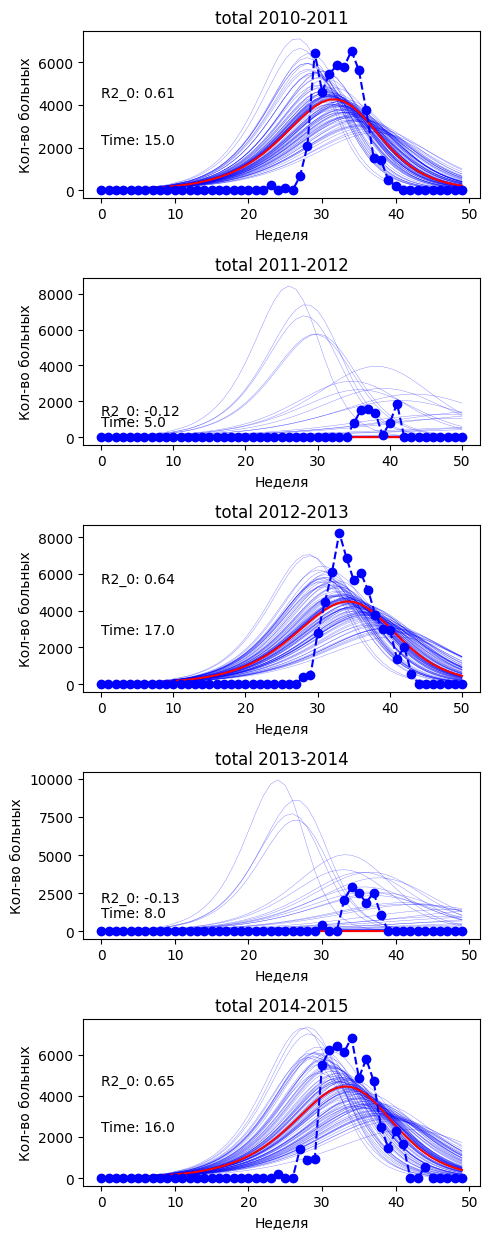

In [10]:
st_year = 2010
years = 5
type ='total'
city = 'samara'

abc_plots(st_year, years, type, city, epsilon=1000)

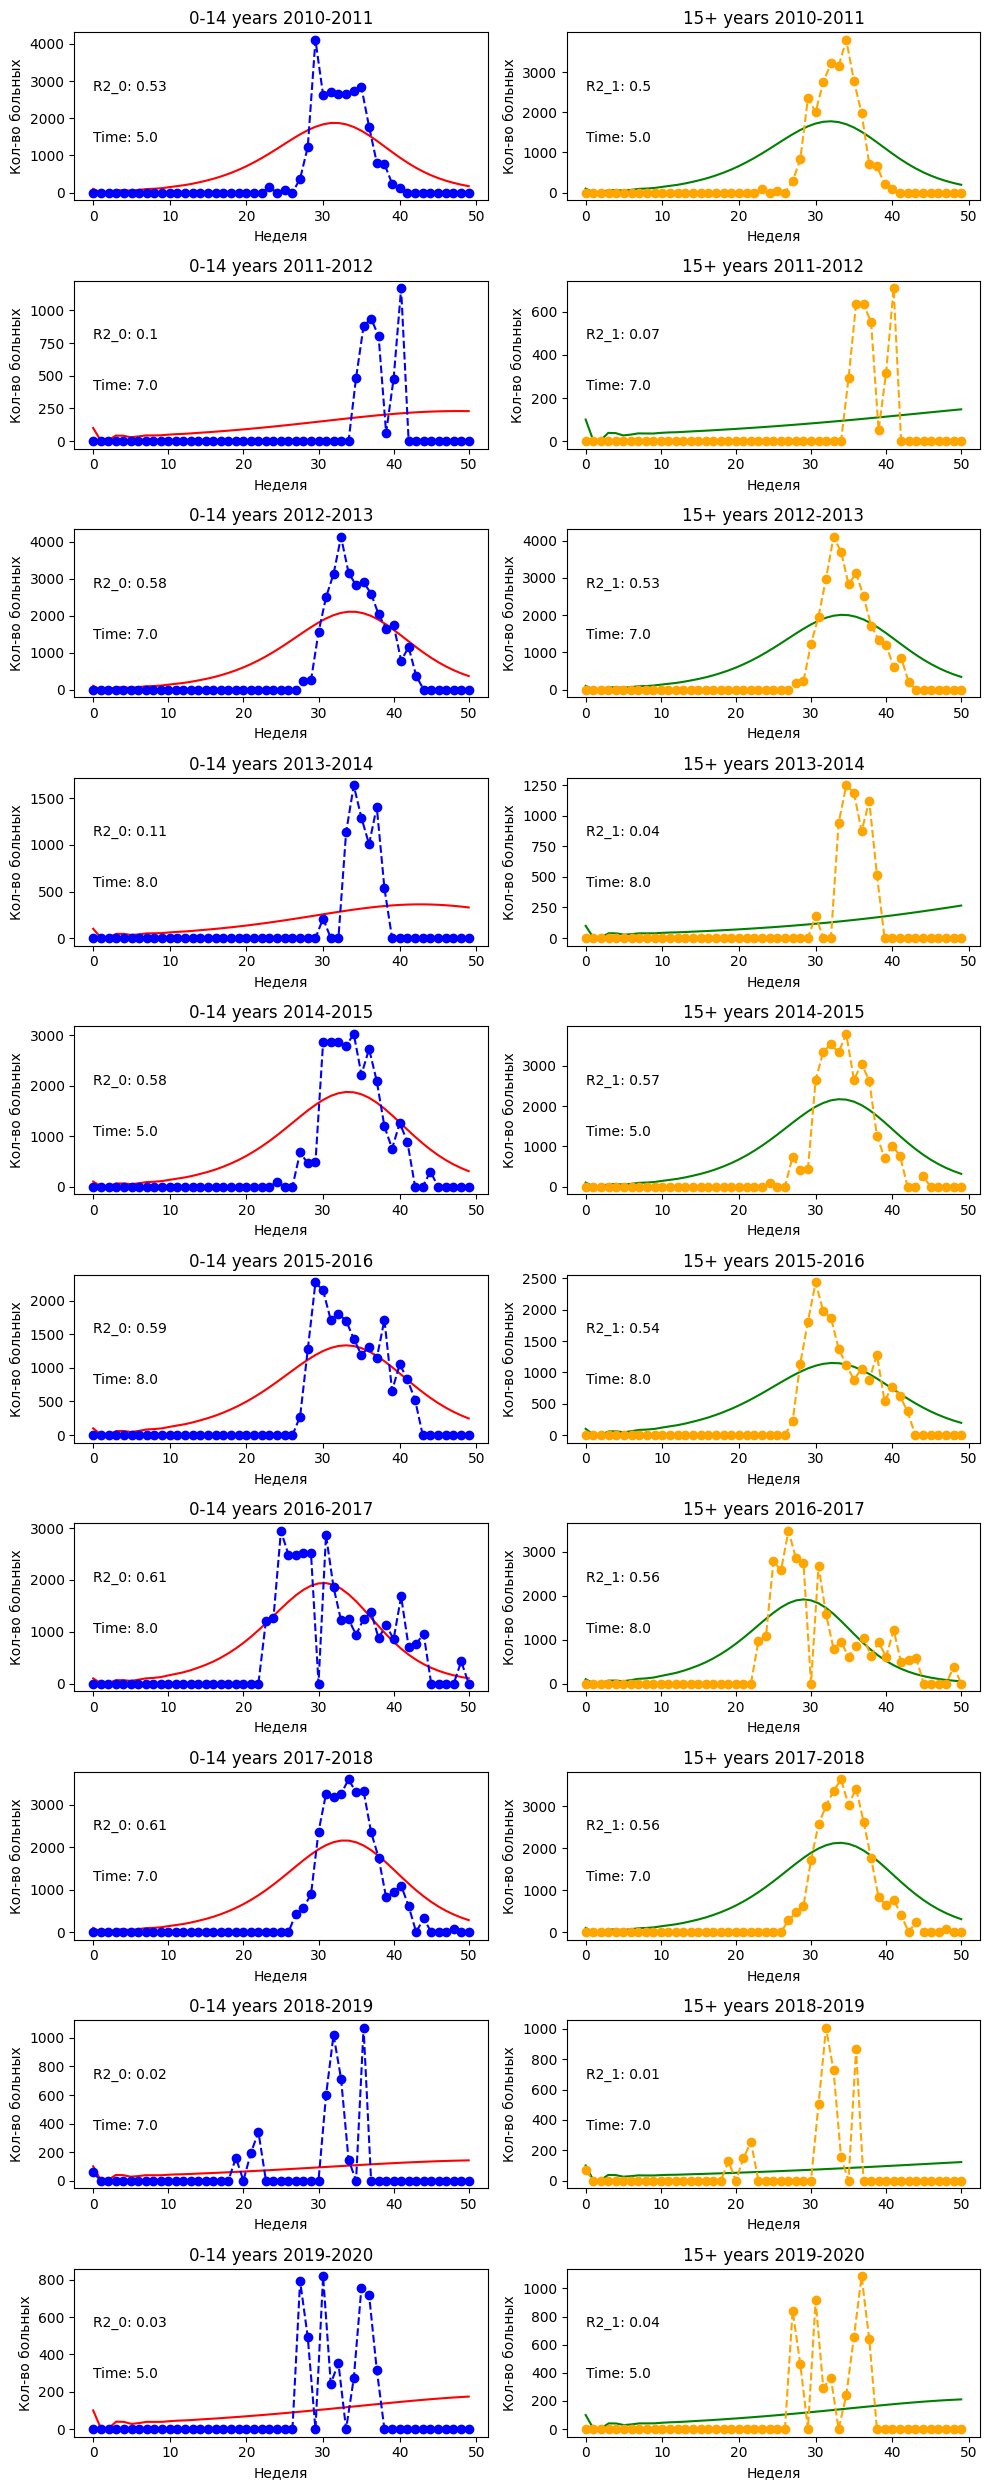

In [11]:
st_year = 2010
years = 10
type ='age'
city = 'samara'
method = 'annealing'

opt_ann_plots(st_year, years, type, city, method)